In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
!pwd

/home/apratim941208/ganalytics


In [3]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [4]:
train_check = load_df()

Loaded train.csv. Shape: (903653, 55)


In [5]:
test_check = load_df('test.csv')

Loaded test.csv. Shape: (804684, 53)


In [6]:
train_df = train_check.copy()


In [7]:
test_df = test_check.copy()

In [8]:
train_df['totals.transactionRevenue']  =train_df['totals.transactionRevenue'].fillna(0.0)

In [9]:
cal = calendar()

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [11]:
train_df['totals.pageviews'].isnull().sum()

100

In [12]:
def preprocess_initial(df):
    columns = [c for c in df.columns if df[c].nunique(dropna=False)==1]
    print("constant columns removed {}".format(list(columns)))
    df = df.drop(columns, axis=1)
    
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    
    holidays = cal.holidays(start = df['date'].min(), end = df['date'].max())
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    df['holiday_var'] = df['date'].isin(holidays)
    
    df = df.drop(['date','sessionId','visitId','visitStartTime','visitNumber'], axis=1)
    df['totals.hits'] = df['totals.hits'].astype('float')
    df['totals.hits'] = (df["totals.hits"] - min(df["totals.hits"]))/(max(df["totals.hits"]) - min(df["totals.hits"])) 
    
    df['totals.pageviews'] = df['totals.pageviews'].fillna(0.0)
    df['totals.pageviews'] = df['totals.pageviews'].astype('float')
    df['totals.pageviews'] = (df["totals.pageviews"] - min(df["totals.pageviews"]))/(max(df["totals.pageviews"]) - min(df["totals.pageviews"]))
    
    
    
    df['totals.bounces'] = df['totals.bounces'].astype(float)
    df['totals.bounces'] = df['totals.bounces'].fillna(0.0)
  
    df['totals.newVisits'] = df['totals.newVisits'].astype(float)
    df['totals.newVisits'] = df['totals.newVisits'].fillna(0.0)
    
    return df

In [13]:
# preprocess_initial(train_df)

In [14]:
train_df.dtypes.value_counts()

object    50
int64      4
bool       1
dtype: int64

In [15]:
train_df = preprocess_initial(train_df)

constant columns removed ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters']


In [16]:
train_df.dtypes.value_counts()

object     26
float64     4
int64       3
bool        2
dtype: int64

In [17]:
train_df.isnull().sum()

channelGrouping                                      0
fullVisitorId                                        0
device.browser                                       0
device.deviceCategory                                0
device.isMobile                                      0
device.operatingSystem                               0
geoNetwork.city                                      0
geoNetwork.continent                                 0
geoNetwork.country                                   0
geoNetwork.metro                                     0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
geoNetwork.subContinent                              0
totals.bounces                                       0
totals.hits                                          0
totals.newVisits                                     0
totals.pageviews                                     0
totals.transactionRevenue                            0
trafficSou

In [18]:
def categorical_engineering(df):
    lbl = preprocessing.LabelEncoder()
    df['holiday_var'] = lbl.fit_transform(df['holiday_var'])
    df['device.isMobile'] = lbl.fit_transform(df['device.isMobile'])
    
    df = df.replace('nan', np.nan)
    
    return df

In [19]:
train_df = categorical_engineering(train_df)

In [20]:
train_df[['device.operatingSystem','trafficSource.source','geoNetwork.region','trafficSource.keyword','geoNetwork.city',
    'trafficSource.campaign','geoNetwork.subContinent','geoNetwork.networkDomain','device.browser','geoNetwork.country','trafficSource.adContent',
    'geoNetwork.metro','trafficSource.adwordsClickInfo.gclId','trafficSource.referralPath']].isnull().sum()

device.operatingSystem                       0
trafficSource.source                         0
geoNetwork.region                            0
trafficSource.keyword                   502929
geoNetwork.city                              0
trafficSource.campaign                       0
geoNetwork.subContinent                      0
geoNetwork.networkDomain                     0
device.browser                               0
geoNetwork.country                           0
trafficSource.adContent                 892707
geoNetwork.metro                             0
trafficSource.adwordsClickInfo.gclId    882092
trafficSource.referralPath              572712
dtype: int64

In [21]:
len(train_df['trafficSource.adContent'])

903653

In [22]:
train_df[['channelGrouping','trafficSource.medium','geoNetwork.continent','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.slot',                 
                 'device.deviceCategory','trafficSource.adwordsClickInfo.isVideoAd','trafficSource.isTrueDirect']].isnull().sum()

channelGrouping                                      0
trafficSource.medium                                 0
geoNetwork.continent                                 0
trafficSource.adwordsClickInfo.adNetworkType    882193
trafficSource.adwordsClickInfo.slot             882193
device.deviceCategory                                0
trafficSource.adwordsClickInfo.isVideoAd        882193
trafficSource.isTrueDirect                      629648
dtype: int64

In [23]:
def categorical_small(df):
    
    df = df.drop(['trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.isVideoAd','trafficSource.isTrueDirect'], axis=1)
    
    small_cols = ['channelGrouping','trafficSource.medium','geoNetwork.continent','device.deviceCategory']
    small_columns = pd.get_dummies(df[small_cols])
    df = pd.concat([df, small_columns],axis=1)
    df = df.drop(small_cols, axis=1)
    
    return df   
    
    

In [24]:
train_df = categorical_small(train_df)

In [25]:
train_df.shape

(903653, 51)

In [26]:
train_df[['device.operatingSystem','trafficSource.source','geoNetwork.region','trafficSource.keyword','geoNetwork.city',
    'trafficSource.campaign','geoNetwork.subContinent','geoNetwork.networkDomain','device.browser','geoNetwork.country','trafficSource.adContent',
    'geoNetwork.metro','trafficSource.adwordsClickInfo.gclId','trafficSource.referralPath']].isnull().sum()

device.operatingSystem                       0
trafficSource.source                         0
geoNetwork.region                            0
trafficSource.keyword                   502929
geoNetwork.city                              0
trafficSource.campaign                       0
geoNetwork.subContinent                      0
geoNetwork.networkDomain                     0
device.browser                               0
geoNetwork.country                           0
trafficSource.adContent                 892707
geoNetwork.metro                             0
trafficSource.adwordsClickInfo.gclId    882092
trafficSource.referralPath              572712
dtype: int64

In [27]:
train_df.select_dtypes(include='object').nunique()

fullVisitorId                           714167
device.browser                              54
device.operatingSystem                      20
geoNetwork.city                            649
geoNetwork.country                         222
geoNetwork.metro                            94
geoNetwork.networkDomain                 28064
geoNetwork.region                          376
geoNetwork.subContinent                     23
totals.transactionRevenue                 5333
trafficSource.adContent                     44
trafficSource.adwordsClickInfo.gclId     17774
trafficSource.adwordsClickInfo.page          8
trafficSource.campaign                      10
trafficSource.campaignCode                   1
trafficSource.keyword                     3659
trafficSource.referralPath                1475
trafficSource.source                       380
dtype: int64

In [28]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

In [29]:
train_df.select_dtypes(include='object').isnull().sum()

fullVisitorId                                0
device.browser                               0
device.operatingSystem                       0
geoNetwork.city                              0
geoNetwork.country                           0
geoNetwork.metro                             0
geoNetwork.networkDomain                     0
geoNetwork.region                            0
geoNetwork.subContinent                      0
trafficSource.adContent                 892707
trafficSource.adwordsClickInfo.gclId    882092
trafficSource.adwordsClickInfo.page     882193
trafficSource.campaign                       0
trafficSource.campaignCode              903652
trafficSource.keyword                   502929
trafficSource.referralPath              572712
trafficSource.source                         0
dtype: int64

In [30]:
train_df[['trafficSource.adContent','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.page','trafficSource.campaignCode']].nunique()

trafficSource.adContent                    44
trafficSource.adwordsClickInfo.gclId    17774
trafficSource.adwordsClickInfo.page         8
trafficSource.campaignCode                  1
dtype: int64

In [31]:
# !pip install category_encoders

In [32]:
import category_encoders as ce

In [33]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0.0)

In [34]:
col_hash = ['device.operatingSystem','device.browser','trafficSource.campaign','geoNetwork.city','geoNetwork.subContinent','geoNetwork.networkDomain','geoNetwork.region',
                  'geoNetwork.country','geoNetwork.metro']

In [35]:
train_df[col_hash].dtypes, train_df[col_hash].nunique(), train_df[col_hash].isnull().sum()

(device.operatingSystem      object
 device.browser              object
 trafficSource.campaign      object
 geoNetwork.city             object
 geoNetwork.subContinent     object
 geoNetwork.networkDomain    object
 geoNetwork.region           object
 geoNetwork.country          object
 geoNetwork.metro            object
 dtype: object, device.operatingSystem         20
 device.browser                 54
 trafficSource.campaign         10
 geoNetwork.city               649
 geoNetwork.subContinent        23
 geoNetwork.networkDomain    28064
 geoNetwork.region             376
 geoNetwork.country            222
 geoNetwork.metro               94
 dtype: int64, device.operatingSystem      0
 device.browser              0
 trafficSource.campaign      0
 geoNetwork.city             0
 geoNetwork.subContinent     0
 geoNetwork.networkDomain    0
 geoNetwork.region           0
 geoNetwork.country          0
 geoNetwork.metro            0
 dtype: int64)

In [36]:
from sklearn.feature_extraction import FeatureHasher

In [37]:
def categorical_large(df):
    
    df = df.drop(['trafficSource.adContent','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.page','trafficSource.campaignCode','fullVisitorId'], axis=1)
    large_cols = ['device.operatingSystem','device.browser','trafficSource.campaign','geoNetwork.city','geoNetwork.subContinent','geoNetwork.networkDomain','geoNetwork.region',
                  'geoNetwork.country','geoNetwork.metro']
    
    return df
    
    
    

In [38]:
train_df['totals.transactionRevenue'].isnull().sum()

0

In [39]:
train_df = train_df.drop('fullVisitorId', axis=1)

In [40]:
from category_encoders import *

In [41]:
col_hash

['device.operatingSystem',
 'device.browser',
 'trafficSource.campaign',
 'geoNetwork.city',
 'geoNetwork.subContinent',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.country',
 'geoNetwork.metro']

In [42]:
enc = HashingEncoder(cols=col_hash, n_components=50).fit(train_df.drop('totals.transactionRevenue', axis=1), train_df['totals.transactionRevenue'])

In [43]:
new_train = enc.transform(train_df.drop('totals.transactionRevenue', axis=1))

In [44]:
new_train.select_dtypes(include='object').columns

Index(['trafficSource.adContent', 'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.keyword', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [45]:
new_train[['trafficSource.adContent', 'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.keyword', 'trafficSource.referralPath',
       'trafficSource.source']].isnull().sum()

trafficSource.adContent                 892707
trafficSource.adwordsClickInfo.gclId    882092
trafficSource.adwordsClickInfo.page     882193
trafficSource.campaignCode              903652
trafficSource.keyword                   502929
trafficSource.referralPath              572712
trafficSource.source                         0
dtype: int64

In [46]:
new_train = new_train.drop(['trafficSource.adContent', 'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode'], axis=1)

In [47]:
new_train = new_train.drop(['trafficSource.keyword','trafficSource.referralPath'], axis=1)

In [ ]:
#dont drop referral path, and keyword

In [51]:
enc_2 = HashingEncoder(cols=['trafficSource.source'], n_components=3).fit(new_train, train_df['totals.transactionRevenue'])

In [52]:
new_train_2 = enc_2.transform(new_train)

In [53]:
new_train_2.shape

(903653, 86)

In [54]:
new_train_2.dtypes.value_counts()

int64      58
uint8      24
float64     4
dtype: int64

In [55]:
new_train_2.isna().any().value_counts()

False    86
dtype: int64

In [56]:
new_train_2.shape

(903653, 86)

In [57]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold

import lightgbm as lgb 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import model_selection, preprocessing, metrics

In [58]:
train_df['totals.transactionRevenue'] = np.log1p(train_df['totals.transactionRevenue'])

In [59]:
train_x, valid_x, train_y, valid_y = train_test_split(new_train_2, train_df["totals.transactionRevenue"], test_size=0.25, random_state=20)

In [60]:
lgb_params = {"objective" : "regression", 
              "metric" : "rmse",
             "num_leaves" : 50,
              "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75,
              "feature_fraction" : 0.8, 
              "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 1200, valid_sets=[lgb_val], early_stopping_rounds=150, verbose_eval=20)

Training until validation scores don't improve for 150 rounds.
[20]	valid_0's rmse: 1.8409
[40]	valid_0's rmse: 1.75237
[60]	valid_0's rmse: 1.70394
[80]	valid_0's rmse: 1.67902
[100]	valid_0's rmse: 1.66291
[120]	valid_0's rmse: 1.65345
[140]	valid_0's rmse: 1.64571
[160]	valid_0's rmse: 1.64002
[180]	valid_0's rmse: 1.63583
[200]	valid_0's rmse: 1.63322
[220]	valid_0's rmse: 1.6313
[240]	valid_0's rmse: 1.62967
[260]	valid_0's rmse: 1.6279
[280]	valid_0's rmse: 1.6269
[300]	valid_0's rmse: 1.62592
[320]	valid_0's rmse: 1.62494
[340]	valid_0's rmse: 1.62438
[360]	valid_0's rmse: 1.62385
[380]	valid_0's rmse: 1.62311
[400]	valid_0's rmse: 1.62282
[420]	valid_0's rmse: 1.62249
[440]	valid_0's rmse: 1.62223
[460]	valid_0's rmse: 1.62218
[480]	valid_0's rmse: 1.62205
[500]	valid_0's rmse: 1.62196
[520]	valid_0's rmse: 1.62179
[540]	valid_0's rmse: 1.62179
[560]	valid_0's rmse: 1.62161
[580]	valid_0's rmse: 1.62123
[600]	valid_0's rmse: 1.62106
[620]	valid_0's rmse: 1.6211
[640]	valid_0's 

In [61]:
model

In [63]:
import matplotlib.pyplot as plt

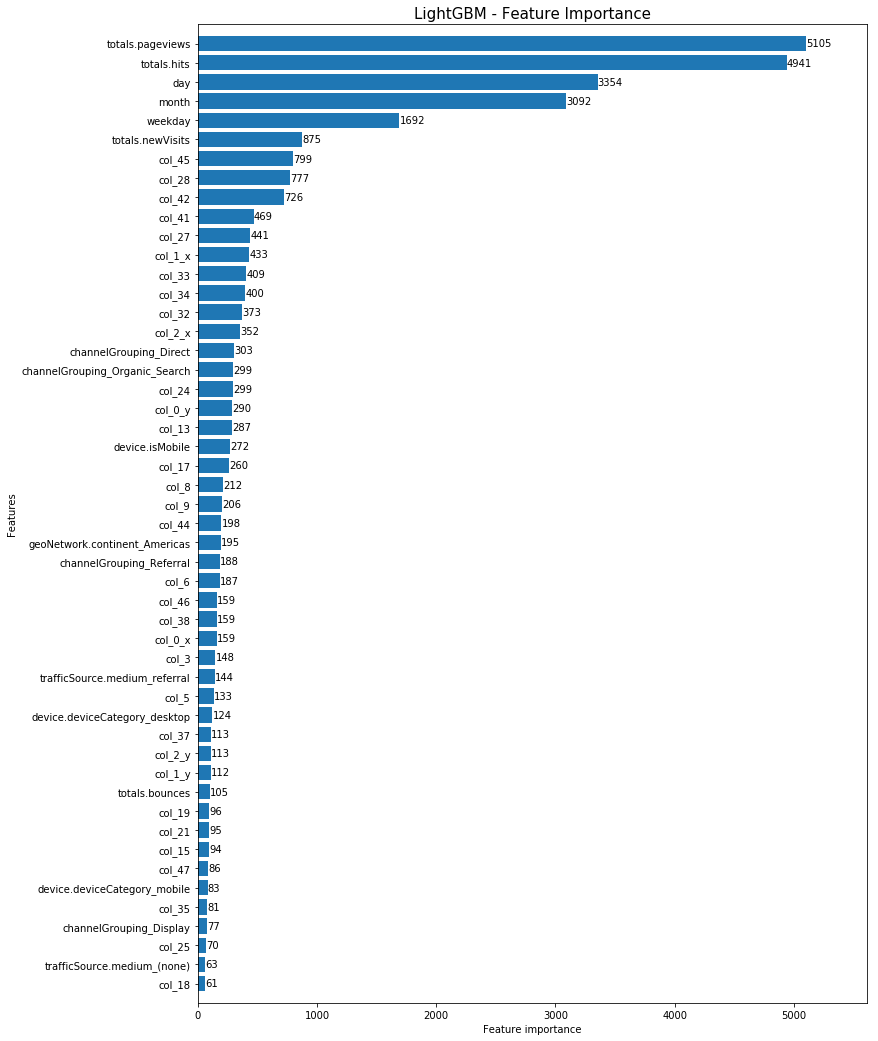

In [64]:
# Show feature importances
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [183]:
import pickle

In [184]:
filename2= 'lgbmodel2.sav'
pickle.dump(model, open(filename2, 'wb'))

In [111]:
import xgboost as xgb

In [112]:
data_dmatrix = xgb.DMatrix(data=new_train_2, label=train_df['totals.transactionRevenue'])

train_x, valid_x, train_y, valid_y = train_test_split(new_train_2, train_df['totals.transactionRevenue'], test_size=0.25, random_state=20)

In [188]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.02,
                max_depth = 50, n_estimators = 50)

In [189]:
xg_reg.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [190]:
preds = xg_reg.predict(valid_x)

In [191]:
rmse = np.sqrt(mean_squared_error(valid_y, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.744329


In [192]:
filename3 = 'xgb2.sav'
pickle.dump(xg_reg, open(filename3, 'wb'))

In [67]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [69]:
# train_x, valid_x, train_y, valid_y = train_test_split(new_train_2, train_df['totals.transactionRevenue'], test_size=0.25, random_state=20)

In [68]:
xgb = XGBRegressor(nthread=-1) 

In [71]:
parameter_xgb = {'min_child_weight':[4,5], 
                 'gamma':[i/10.0 for i in range(4,6)],
                 'subsample':[i/10.0 for i in range(7,9)],
                 'colsample_bytree':[i/10.0 for i in range(7,9)],
                 'max_depth': [3, 5],
                 'learning_rate':[0.02],
                 'n_estimators':[10, 15]}

In [76]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [77]:
cv1 = KFold(n_splits=5, shuffle=True)
grid = GridSearchCV(xgb, parameter_xgb, scoring='neg_mean_squared_error', cv=cv1)
grid.fit(new_train_2, train_df['totals.transactionRevenue'])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [4, 5], 'gamma': [0.4, 0.5], 'subsample': [0.7, 0.8], 'colsample_bytree': [0.7, 0.8], 'max_depth': [3, 5], 'learning_rate': [0.02], 'n_estimators': [10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [79]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=4, missing=None,
       n_estimators=15, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [84]:
grid.best_score_

-3.58321410904326

In [86]:
grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.4,
 'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 15,
 'subsample': 0.8}

In [85]:
grid.cv_results_

/home/apratim941208/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/apratim941208/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/apratim941208/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, *

{'mean_fit_time': array([4.88871536, 4.62320452, 5.51847734, 5.37376003, 4.71750708,
        4.63323717, 5.48476605, 5.32356796, 5.51148896, 5.34714937,
        6.66876111, 6.41953459, 5.53024783, 5.50784526, 6.83271227,
        6.558816  , 4.68587742, 4.56176839, 5.39569225, 5.26843066,
        4.61097312, 4.53132281, 5.36987581, 5.24590549, 5.39760318,
        5.32738638, 6.5416584 , 6.35791607, 5.27718968, 5.25253105,
        6.55334616, 6.3127811 , 4.80806074, 4.73731956, 5.65470338,
        5.57636538, 4.75891819, 4.65014796, 5.66173697, 5.61458025,
        5.83993564, 5.63621025, 7.02969337, 6.93341184, 5.82019386,
        5.6253346 , 7.21124177, 6.94370122, 4.86472116, 4.73758163,
        5.70732322, 5.55960813, 4.85412369, 4.73900104, 5.70275016,
        5.48999238, 5.80000067, 5.66706562, 7.11482749, 6.89570928,
        5.7446003 , 5.59378839, 7.06078224, 6.84346175]),
 'std_fit_time': array([0.19292264, 0.07822261, 0.02775683, 0.04723283, 0.03968494,
        0.04343624, 0.022

In [87]:
grid.n_splits_

5

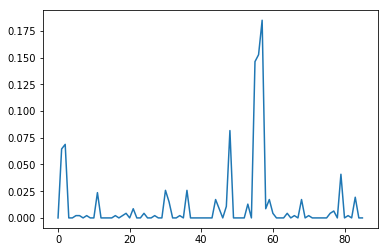

In [107]:
ax = plt.figure()

plt.plot(grid.best_estimator_.feature_importances_)

In [113]:
print(mean_squared_error(valid_y, grid.best_estimator_.predict(valid_x))) 

3.590446128766214


In [81]:
import pickle

In [83]:
filename4 = 'grid_xgb.sav'
pickle.dump(grid, open(filename4, 'wb'))

In [114]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# rest of the code

In [115]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [116]:
from keras.layers import Activation, Dense, Dropout

In [117]:
train_x, valid_x, train_y, valid_y = train_test_split(new_train_2, train_df['totals.transactionRevenue'], test_size=0.25, random_state=20)

In [118]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((677739, 86), (225914, 86), (677739,), (225914,))

In [119]:
from sklearn.preprocessing import MinMaxScaler

In [121]:
train_y = train_y.values.reshape(-1,1)
valid_y = valid_y.values.reshape(-1,1)

In [122]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((677739, 86), (225914, 86), (677739, 1), (225914, 1))

In [124]:
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(train_x)
scalarY.fit(train_y)
train_x = scalarX.transform(train_x)
train_y = scalarY.transform(train_y)

/home/apratim941208/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [130]:
model2 = Sequential()
model2.add(Dense(128, input_dim=86, kernel_initializer='random_normal', activation='relu'))
model2.add(Dense(64, kernel_initializer='random_normal'))
model2.add(Dense(64, kernel_initializer='random_normal'))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1))
# Compile model
model2.compile(loss='mean_squared_error', optimizer='rmsprop')

In [131]:

model2.fit(train_x, train_y, epochs=10, verbose=0)

In [ ]:
valid_x = scalarX.transform(valid_x)
valid_y = scalarY.transform(valid_y)


In [143]:
predictions_NN = model2.predict(valid_x)

print(np.sqrt(metrics.mean_squared_error(valid_y,predictions_NN)))

2.018945717574451


In [144]:
filename5 = 'NN1.sav'
pickle.dump(model2, open(filename5, 'wb'))